# PLACES Health Data

This notebook gathers the [PLACES](https://chronicdata.cdc.gov/500-Cities-Places/PLACES-Place-Data-GIS-Friendly-Format-2021-release/vgc8-iyc4/data)

## Importing the Packages

In [2]:
### Import Libraries

# File manipulation

import os # For working with Operating System
from sys import platform # Diagnose operating system
import urllib # For accessing websites
import zipfile # For extracting from Zipfiles
from io import BytesIO # For reading bytes objects

# Analysis

import numpy as np # For working with Arrays
import pandas as pd # Data Manipulation
import geopandas as gpd # Spatial Data Manipulation

# Visualization

from pprint import pprint # Pretty Printing
import matplotlib.pyplot as plt # Basic Plotting
#import contextily # Base Map Visualization

import warnings
warnings.filterwarnings('ignore') # Ignores some warnings

## Importing the Data

In [3]:
url = ('https://raw.githubusercontent.com/RwHendrickson/MappingGZ/main/Prototype/Notebooks/CleaningData/Health/PLACES_2021.csv')

cdc_health_data = pd.read_csv(url)

cdc_health_data.head()

,StateAbbr,StateDesc,CountyName,CountyFIPS,TractFIPS,TotalPopulation,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,...,OBESITY_Crude95CI,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation
0,MN,Minnesota,Anoka,27003,27003050235,2769,10.4,"( 8.6, 12.4)",22.1,"(20.8, 23.2)",...,"(35.6, 38.8)",10.4,"( 9.3, 11.5)",32.5,"(30.8, 34.3)",2.6,"( 2.3, 2.9)",10.3,"( 6.4, 15.0)",POINT (-93.24003196 45.28024905)
1,MN,Minnesota,Carver,27019,27019090401,4545,7.1,"( 5.9, 8.5)",17.7,"(16.9, 18.5)",...,"(26.3, 28.6)",7.5,"( 6.8, 8.3)",25.8,"(24.1, 27.9)",2.0,"( 1.8, 2.1)",5.7,"( 4.1, 7.9)",POINT (-93.71571775 44.84363993)
2,MN,Minnesota,Anoka,27003,27003050217,2724,8.2,"( 6.7, 9.9)",21.5,"(20.2, 22.7)",...,"(33.6, 37.1)",9.3,"( 8.1, 10.3)",31.3,"(29.7, 33.4)",2.3,"( 2.1, 2.6)",6.9,"( 4.3, 10.2)",POINT (-93.30598699 45.28030762)
3,MN,Minnesota,Anoka,27003,27003050114,2803,9.0,"( 7.2, 11.2)",21.2,"(20.0, 22.4)",...,"(33.6, 36.9)",9.2,"( 8.1, 10.4)",30.8,"(29.3, 32.6)",2.3,"( 2.0, 2.6)",7.3,"( 4.3, 10.9)",POINT (-93.36812552 45.33911414)
4,MN,Minnesota,Blue Earth,27013,27013170700,2817,12.4,"( 9.9, 15.6)",14.6,"(13.8, 15.3)",...,"(30.6, 34.7)",10.6,"( 9.5, 11.7)",30.2,"(27.4, 32.7)",2.2,"( 2.0, 2.4)",15.2,"(10.7, 20.8)",POINT (-94.0078327 44.16242874)


## Converting to GDF

In [4]:
crs = 'EPSG:4326'

cdc_health_gdf = gpd.GeoDataFrame(cdc_health_data, crs = crs, geometry = gpd.GeoSeries.from_wkt(cdc_health_data.Geolocation))

cdc_health_gdf.head()

,StateAbbr,StateDesc,CountyName,CountyFIPS,TractFIPS,TotalPopulation,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,...,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation,geometry
0,MN,Minnesota,Anoka,27003,27003050235,2769,10.4,"( 8.6, 12.4)",22.1,"(20.8, 23.2)",...,10.4,"( 9.3, 11.5)",32.5,"(30.8, 34.3)",2.6,"( 2.3, 2.9)",10.3,"( 6.4, 15.0)",POINT (-93.24003196 45.28024905),POINT (-93.24003 45.28025)
1,MN,Minnesota,Carver,27019,27019090401,4545,7.1,"( 5.9, 8.5)",17.7,"(16.9, 18.5)",...,7.5,"( 6.8, 8.3)",25.8,"(24.1, 27.9)",2.0,"( 1.8, 2.1)",5.7,"( 4.1, 7.9)",POINT (-93.71571775 44.84363993),POINT (-93.71572 44.84364)
2,MN,Minnesota,Anoka,27003,27003050217,2724,8.2,"( 6.7, 9.9)",21.5,"(20.2, 22.7)",...,9.3,"( 8.1, 10.3)",31.3,"(29.7, 33.4)",2.3,"( 2.1, 2.6)",6.9,"( 4.3, 10.2)",POINT (-93.30598699 45.28030762),POINT (-93.30599 45.28031)
3,MN,Minnesota,Anoka,27003,27003050114,2803,9.0,"( 7.2, 11.2)",21.2,"(20.0, 22.4)",...,9.2,"( 8.1, 10.4)",30.8,"(29.3, 32.6)",2.3,"( 2.0, 2.6)",7.3,"( 4.3, 10.9)",POINT (-93.36812552 45.33911414),POINT (-93.36813 45.33911)
4,MN,Minnesota,Blue Earth,27013,27013170700,2817,12.4,"( 9.9, 15.6)",14.6,"(13.8, 15.3)",...,10.6,"( 9.5, 11.7)",30.2,"(27.4, 32.7)",2.2,"( 2.0, 2.4)",15.2,"(10.7, 20.8)",POINT (-94.0078327 44.16242874),POINT (-94.00783 44.16243)


## Clipping the Data

In [5]:
def clip_to_extent(cdc):
    '''This function returns the dataset clipped to the boundaries of Minneapolis and the boundary itself.
    Warning: This function will access the geojson of Minneapolis from GitHub if it's not in the current working directory or local Boundary folder.
    See this link for more info: https://github.com/RwHendrickson/MappingGZ/blob/main/Prototype/Notebooks/CleaningData/Boundary/DefineBoundary.ipynb'''
    
    # Look for mpls_boundary
    
    cwd = os.getcwd() # Current working directory

    os.chdir('..') # Bump up one directory

    if 'mpls_boundary.shp' in os.listdir(cwd): # Boundary shapefile in the current working directory
        mpls_boundary = gpd.read_file(r'mpls_boundary.shp') # Load extent as GeoDataFrame

    elif 'mpls_boundary.geojson' in os.listdir(cwd): # Boundary json in the current working directory
        mpls_boundary = gpd.read_file(r'mpls_boundary.geojson') # Load extent as GeoDataFrame

    elif 'Boundary' in os.listdir(): # Boundary folder on computer
        if 'mpls_boundary.geojson' in os.listdir('Boundary'): # Is the json there?
            path = 'Boundary' + slash + 'mpls_boundary.geojson'
            mpls_boundary = gpd.read_file(path)

        else:
            print('''Can't find mpls_boundary.geojson. Accessing from GitHub.\n 
            See this link for more info: \n\nhttps://github.com/RwHendrickson/MappingGZ/blob/main/Prototype/Notebooks/CleaningData/Boundary/DefineBoundary.ipynb''')
            url = 'https://raw.githubusercontent.com/RwHendrickson/MappingGZ/main/Prototype/Notebooks/CleaningData/Boundary/mpls_boundary.geojson'
            mpls_boundary = gpd.read_file(url) # Load extent as GeoDataFrame
    else:
            print('''Can't find mpls_boundary.geojson. Accessing from GitHub.\n 
            See this link for more info: \n\nhttps://github.com/RwHendrickson/MappingGZ/blob/main/Prototype/Notebooks/CleaningData/Boundary/DefineBoundary.ipynb''')
            url = 'https://raw.githubusercontent.com/RwHendrickson/MappingGZ/main/Prototype/Notebooks/CleaningData/Boundary/mpls_boundary.geojson'
            mpls_boundary = gpd.read_file(url) # Load extent as GeoDataFrame


    os.chdir(cwd) # Go back to current working directory
    
    if cdc.crs != 'EPSG:26915': # Ensures gdf is in the same CRS
        cdc = cdc.to_crs('EPSG:26915')
    
    clipped = gpd.clip(cdc, mpls_boundary) # Clip
    
    return clipped, mpls_boundary

In [6]:
cdc_clp, mpls_boundary = clip_to_extent(cdc_health_gdf)

Can't find mpls_boundary.geojson. Accessing from GitHub.
 
            See this link for more info: 

https://github.com/RwHendrickson/MappingGZ/blob/main/Prototype/Notebooks/CleaningData/Boundary/DefineBoundary.ipynb


<AxesSubplot:>

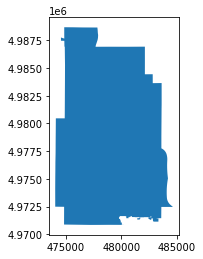

In [7]:
mpls_boundary.plot()

<Derived Projected CRS: EPSG:26915>
Name: NAD83 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 96°W and 90°W - onshore and offshore. Canada - Manitoba; Nunavut; Ontario. United States (USA) - Arkansas; Illinois; Iowa; Kansas; Louisiana; Michigan; Minnesota; Mississippi; Missouri; Nebraska; Oklahoma; Tennessee; Texas; Wisconsin.
- bounds: (-96.0, 25.61, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

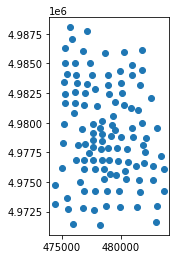

In [8]:
cdc_clp.plot()
cdc_clp.crs

## Creating a Shapefile/GeoJSON

In [11]:
cdc_clp.to_file(r'mpls_health_data.shp') # Save shapefile
cdc_clp.to_file(r'mpls_health_data.geojson', driver='GeoJSON')